<a href="https://colab.research.google.com/github/Reihannnn/pi-klasifikasi/blob/main/Klasifikasi_jajanan_mobileNetV2_Revisi.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# import Library

In [4]:
import os
import shutil
import pathlib
import numpy as np
import tensorflow as tf
from matplotlib import pyplot as plt
from google.colab import drive
from sklearn.metrics import classification_report, f1_score, confusion_matrix
import seaborn as sns
import warnings

## Set seeds untuk reproducibility

In [5]:
tf.random.set_seed(123)
np.random.seed(123)
warnings.filterwarnings('ignore')

In [6]:
drive.mount('/content/drive/')
PATH = '/content/drive/MyDrive/jajanan_Betawi_pngV2'
data_dir = pathlib.Path(PATH)

Mounted at /content/drive/


# Data preparation

In [7]:
print(f'\nDistribution Image')
total = 0
for i, label in enumerate(os.listdir(data_dir)):
    label_dir = os.path.join(data_dir, label)
    len_label_dir = len(os.listdir(label_dir))
    print(f'{i+1}. {label}: {len_label_dir}')
    total += len_label_dir

print("Total dataset:", total)


Distribution Image
1. Kue_ape: 182
2. Selendang_mayang: 190
3. Kue_dongkal: 163
4. Kerak_telor: 182
5. Kue_rangi: 188
Total dataset: 905


# Data Splitting

In [8]:
# ===== PROPER DATA SPLITTING =====
# Parameters
BATCH_SIZE = 32
IMG_SIZE = (224, 224)
SEED = 123

# Step 1: Split menjadi 70% train, 30% temp (untuk val+test)
train_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.3,
    subset="training",
    seed=SEED,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE
)

temp_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.3,
    subset="validation",
    seed=SEED,
    image_size=IMG_SIZE,
)



Found 905 files belonging to 5 classes.
Using 634 files for training.
Found 905 files belonging to 5 classes.
Using 271 files for validation.


In [9]:
# Step 2: Split temp_ds menjadi validation (20%) dan test (10%)
temp_batches = tf.data.experimental.cardinality(temp_ds).numpy()
val_batches = int(0.67 * temp_batches)  # 20% dari total
test_batches = temp_batches - val_batches  # 10% dari total

val_ds = temp_ds.take(val_batches)
test_ds = temp_ds.skip(val_batches)


print(f"\nDataset Split:")
print(f"Training: {tf.data.experimental.cardinality(train_ds).numpy() * BATCH_SIZE} samples (~70%)")
print(f"Validation: {tf.data.experimental.cardinality(val_ds).numpy() * BATCH_SIZE} samples (~20%)")
print(f"Testing: {tf.data.experimental.cardinality(test_ds).numpy() * BATCH_SIZE} samples (~10%)")

# Get class names
class_names = train_ds.class_names
print(f'\nClass names: {class_names}')


Dataset Split:
Training: 640 samples (~70%)
Validation: 192 samples (~20%)
Testing: 96 samples (~10%)

Class names: ['Kerak_telor', 'Kue_ape', 'Kue_dongkal', 'Kue_rangi', 'Selendang_mayang']


In [10]:
def count_samples_per_class(dataset, class_names):
    """Menghitung jumlah sampel per kelas dalam dataset"""
    class_counts = {class_name: 0 for class_name in class_names}

    # Unbatch dataset dulu untuk akurasi
    unbatched_dataset = dataset.unbatch()

    for image, label in unbatched_dataset:
        label_numpy = label.numpy()
        class_name = class_names[label_numpy]
        class_counts[class_name] += 1

    return class_counts

# Hitung distribusi asli dari folder (gunakan urutan yang sama dengan class_names)
print("Original Distribution from Folder:")
print("=" * 40)
total = 0
original_counts = {}
for i, class_name in enumerate(class_names):  # Gunakan class_names dari TensorFlow
    label_dir = os.path.join(data_dir, class_name)
    if os.path.isdir(label_dir):  # Pastikan itu folder
        len_label_dir = len(os.listdir(label_dir))
        print(f'{i+1}. {class_name}: {len_label_dir}')
        original_counts[class_name] = len_label_dir
        total += len_label_dir
print(f"Total dataset: {total}")

print("\n" + "="*60)

# Hitung distribusi untuk setiap split
train_counts = count_samples_per_class(train_ds, class_names)
val_counts = count_samples_per_class(val_ds, class_names)
test_counts = count_samples_per_class(test_ds, class_names)

# Tampilkan hasil split dengan perbandingan
print("Dataset Distribution per Class (After Split):")
print("=" * 70)
print(f"{'Class':<15} {'Original':<10} {'Training':<10} {'Validation':<12} {'Testing':<8} {'Total':<8}")
print("-" * 70)

for class_name in class_names:
    original_count = original_counts.get(class_name, 0)
    train_count = train_counts[class_name]
    val_count = val_counts[class_name]
    test_count = test_counts[class_name]
    split_total = train_count + val_count + test_count

    print(f"{class_name:<15} {original_count:<10} {train_count:<10} {val_count:<12} {test_count:<8} {split_total:<8}")

print("-" * 70)

# Verifikasi total
total_train = sum(train_counts.values())
total_val = sum(val_counts.values())
total_test = sum(test_counts.values())
total_split = total_train + total_val + total_test

print(f"{'TOTAL':<15} {total_train:<10} {total_val:<12} {total_test:<8} {total_split:<8}")

# Bandingkan dengan original per kelas
print(f"\nPer-Class Comparison:")
all_match = True
for class_name in class_names:
    original_count = original_counts.get(class_name, 0)
    split_total = train_counts[class_name] + val_counts[class_name] + test_counts[class_name]

    if original_count != split_total:
        print(f"⚠️  {class_name}: Original {original_count} vs Split {split_total} (diff: {original_count - split_total})")
        all_match = False

if all_match:
    print("✅ All classes match perfectly!")
else:
    print("\nPossible reasons for differences:")
    print("- Invalid/corrupted image files filtered by TensorFlow")
    print("- Unsupported image formats")
    print("- Hidden files or non-image files in folders")

def count_actual_samples(dataset):
    """Hitung sampel secara manual"""
    count = 0
    for batch in dataset:
        count += len(batch[0])  # batch[0] adalah images
    return count

# Hitung ulang dengan cara manual
actual_train = count_actual_samples(train_ds)
actual_val = count_actual_samples(val_ds)
actual_test = count_actual_samples(test_ds)

print(f"Manual Count:")
print(f"Training: {actual_train}")
print(f"Validation: {actual_val}")
print(f"Testing: {actual_test}")
print(f"Total: {actual_train + actual_val + actual_test}")

print(f"BATCH_SIZE yang digunakan: {BATCH_SIZE}")
print(f"Cardinality train_ds: {tf.data.experimental.cardinality(train_ds).numpy()}")
print(f"Cardinality val_ds: {tf.data.experimental.cardinality(val_ds).numpy()}")
print(f"Cardinality test_ds: {tf.data.experimental.cardinality(test_ds).numpy()}")

Original Distribution from Folder:
1. Kerak_telor: 182
2. Kue_ape: 182
3. Kue_dongkal: 163
4. Kue_rangi: 188
5. Selendang_mayang: 190
Total dataset: 905

Dataset Distribution per Class (After Split):
Class           Original   Training   Validation   Testing  Total   
----------------------------------------------------------------------
Kerak_telor     182        132        33           22       187     
Kue_ape         182        130        41           13       184     
Kue_dongkal     163        104        41           14       159     
Kue_rangi       188        131        42           15       188     
Selendang_mayang 190        137        35           15       187     
----------------------------------------------------------------------
TOTAL           634        192          79       905     

Per-Class Comparison:
⚠️  Kerak_telor: Original 182 vs Split 187 (diff: -5)
⚠️  Kue_ape: Original 182 vs Split 184 (diff: -2)
⚠️  Kue_dongkal: Original 163 vs Split 159 (diff: 4)
⚠️  S

# Data Preprocessing

In [11]:
AUTOTUNE = tf.data.AUTOTUNE

# Cache and prefetch for performance
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

# Data augmentation (hanya untuk training)
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal_and_vertical"),
    tf.keras.layers.RandomRotation(0.3),
    tf.keras.layers.RandomZoom(0.2),
    tf.keras.layers.RandomContrast(0.3),
    tf.keras.layers.RandomBrightness(0.2)
])

# Normalization layer
normalization_layer = tf.keras.layers.Rescaling(1./255)

## visualisasi beberapa gambar training dan augmentasi data

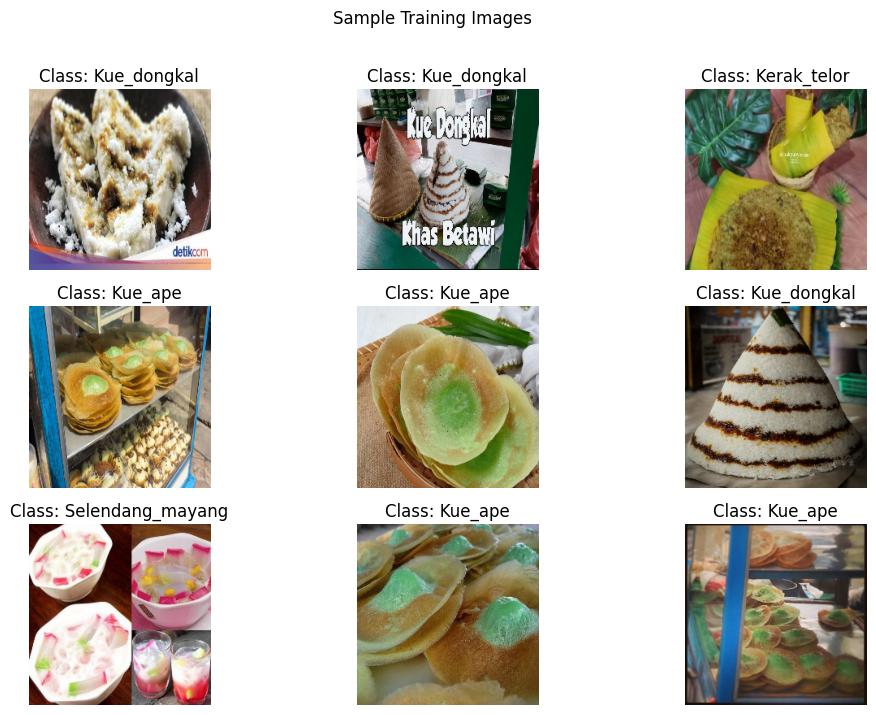

In [12]:
# ===== VISUALISASI DATA =====
# Visualisasi beberapa gambar training
plt.figure(figsize=(12, 8))
for images, labels in train_ds.take(1):
    for i in range(min(9, len(images))):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(f"Class: {class_names[labels[i]]}")
        plt.axis("off")
plt.suptitle("Sample Training Images")
plt.show()

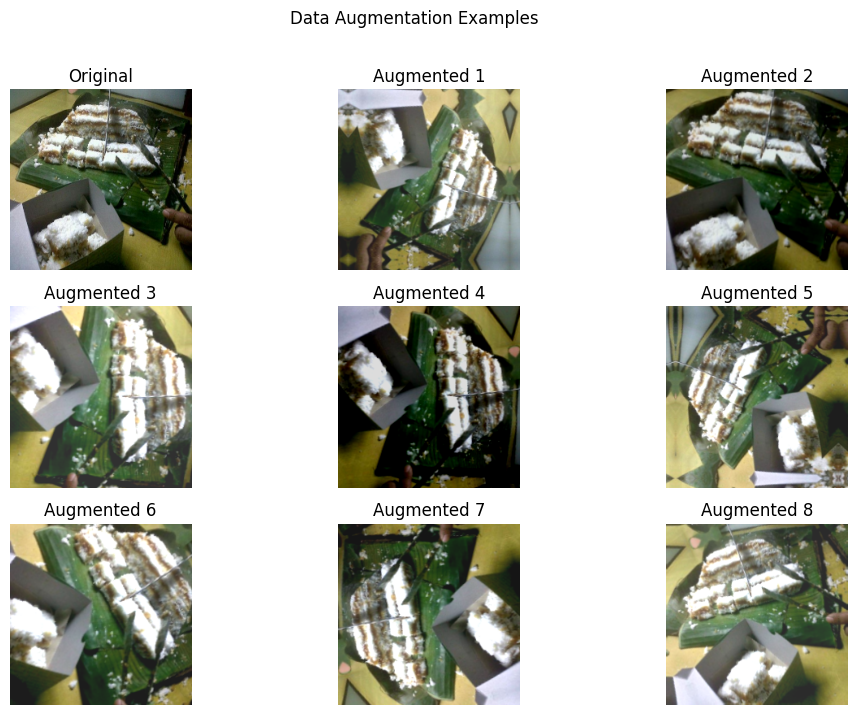

In [13]:
# Visualisasi augmentasi
for image, _ in train_ds.take(1):
    plt.figure(figsize=(12, 8))
    first_image = image[0]
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        if i == 0:
            plt.imshow(first_image.numpy().astype("uint8"))
            plt.title("Original")
        else:
            augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
            plt.imshow(augmented_image[0] / 255)
            plt.title(f"Augmented {i}")
        plt.axis('off')
    plt.suptitle("Data Augmentation Examples")
    plt.show()

# Model building

In [14]:
# Base model (MobileNetV2)
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(
    input_shape=IMG_SHAPE,
    include_top=False,
    weights='imagenet'
)
base_model.trainable = False

# Global average pooling
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [15]:
## function pembuatan model

def build_model():
    num_classes = len(class_names)

    model = tf.keras.Sequential([
        tf.keras.Input(shape=IMG_SHAPE),
        data_augmentation,
        normalization_layer,
        base_model,
        global_average_layer,
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(num_classes, activation='softmax')
    ])

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
        loss=tf.keras.losses.SparseCategoricalCrossentropy(),
        metrics=['accuracy']
    )

    return model

# Training Setup


In [16]:
# Callbacks
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    "best_jajanan_betawi_model.keras" ,
    monitor="val_accuracy",
    save_best_only=True,
    verbose=1
)

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor="val_accuracy",
    patience=10,
    mode="max",
    verbose=1,
    restore_best_weights=True
)

lr_reduce = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    verbose=1,
    min_lr=1e-6
)

## Model Train

In [17]:
# Build and train model
model = build_model()
model.summary()

# trainning model
print("\n===== TRAINING PHASE =====")
history = model.fit(
    train_ds,
    epochs=50,  # Reduced for faster training
    validation_data=val_ds,
    callbacks=[model_checkpoint, early_stopping, lr_reduce],
    verbose=1
)

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling (Rescaling)           │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,423,109 (9.24 MB)

 Trainable params: 164,869 (644.02 KB)

 Non-trainable params: 2,258,240 (8.61 MB)


===== TRAINING PHASE =====
Epoch 1/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 0.4856 - loss: 1.5824
Epoch 1: val_accuracy improved from -inf to 0.85938, saving model to best_jajanan_betawi_model.keras
20/20 ━━━━━━━━━━━━━━━━━━━━ 15s 347ms/step - accuracy: 0.4932 - loss: 1.5566 - val_accuracy: 0.8594 - val_loss: 0.3796 - learning_rate: 0.0010
Epoch 2/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - accuracy: 0.8858 - loss: 0.3518
Epoch 2: val_accuracy improved from 0.85938 to 0.91146, saving model to best_jajanan_betawi_model.keras
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 97ms/step - accuracy: 0.8862 - loss: 0.3500 - val_accuracy: 0.9115 - val_loss: 0.2490 - learning_rate: 0.0010
Epoch 3/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - accuracy: 0.9283 - loss: 0.1936
Epoch 3: val_accuracy improved from 0.91146 to 0.92188, saving model to best_jajanan_betawi_model.keras
20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 97ms/step - accuracy: 0.9280 - loss: 0.1945 - val_accuracy: 0.9219 - val_loss: 0.2308 - learning

# Visualisasi dan Evaluasi

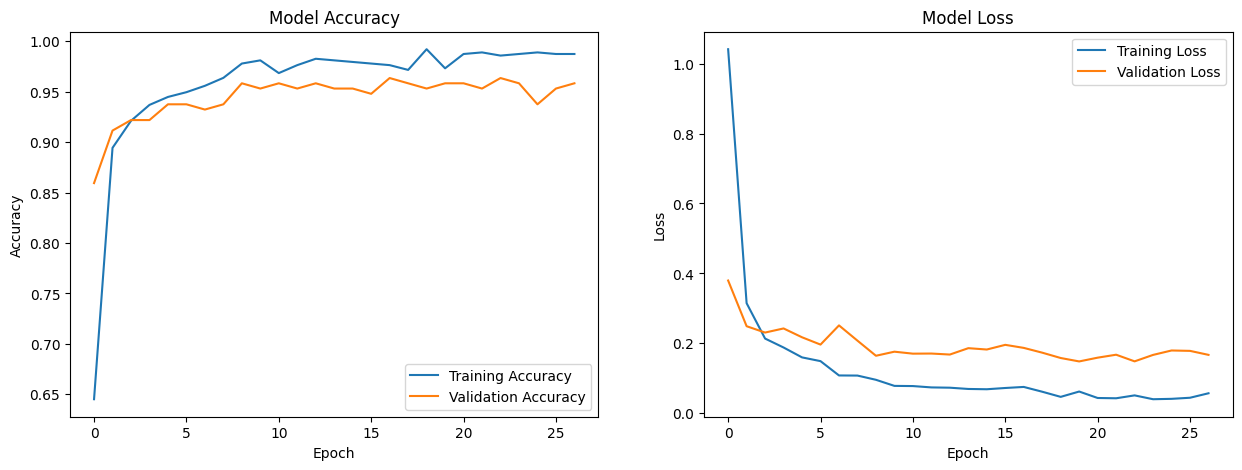

In [18]:
# visualisasi

# Plot training history
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend()
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend()
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

## evaluasi

In [19]:
# Load best model
print("\n===== LOADING BEST MODEL =====")
best_model = tf.keras.models.load_model('best_jajanan_betawi_model.keras')

# ===== VALIDATION SET EVALUATION =====
print("\n===== TRAINING SET EVALUATION =====")
val_loss, val_acc = best_model.evaluate(val_ds, verbose=0)
print(f'Validation Accuracy: {val_acc:.4f}')
print(f'Validation Loss: {val_loss:.4f}')

print("\n===== VALIDATION SET EVALUATION =====")
val_loss, val_acc = best_model.evaluate(val_ds, verbose=0)
print(f'Validation Accuracy: {val_acc:.4f}')
print(f'Validation Loss: {val_loss:.4f}')

# ===== TEST SET EVALUATION (FINAL EVALUATION) =====
print("\n===== TEST SET EVALUATION (FINAL RESULTS) =====")
test_loss, test_acc = best_model.evaluate(test_ds, verbose=0)
print(f'Test Accuracy: {test_acc:.4f}')
print(f'Test Loss: {test_loss:.4f}')


===== LOADING BEST MODEL =====

===== TRAINING SET EVALUATION =====
Validation Accuracy: 0.9635
Validation Loss: 0.1870

===== VALIDATION SET EVALUATION =====
Validation Accuracy: 0.9635
Validation Loss: 0.1870

===== TEST SET EVALUATION (FINAL RESULTS) =====
Test Accuracy: 0.9367
Test Loss: 0.2167


In [20]:
# Detailed evaluation on test set
y_true = []
y_pred = []
y_pred_proba = []

print("Generating predictions on test set...")
for images, labels in test_ds:
    preds = best_model.predict(images, verbose=0)
    y_true.extend(labels.numpy())
    y_pred.extend(np.argmax(preds, axis=1))
    y_pred_proba.extend(preds)

# Classification report
print("\n===== CLASSIFICATION REPORT (TEST SET) =====")
print(classification_report(y_true, y_pred, target_names=class_names))

# F1 Score
f1_weighted = f1_score(y_true, y_pred, average='weighted')
f1_macro = f1_score(y_true, y_pred, average='macro')
print(f'\nF1 Score (weighted): {f1_weighted:.4f}')
print(f'F1 Score (macro): {f1_macro:.4f}')

Generating predictions on test set...

===== CLASSIFICATION REPORT (TEST SET) =====
                  precision    recall  f1-score   support

     Kerak_telor       0.86      1.00      0.92        12
         Kue_ape       0.88      1.00      0.94        15
     Kue_dongkal       0.94      0.94      0.94        17
       Kue_rangi       1.00      0.80      0.89        15
Selendang_mayang       1.00      0.95      0.97        20

        accuracy                           0.94        79
       macro avg       0.94      0.94      0.93        79
    weighted avg       0.94      0.94      0.94        79


F1 Score (weighted): 0.9362
F1 Score (macro): 0.9330


## convolution matrix

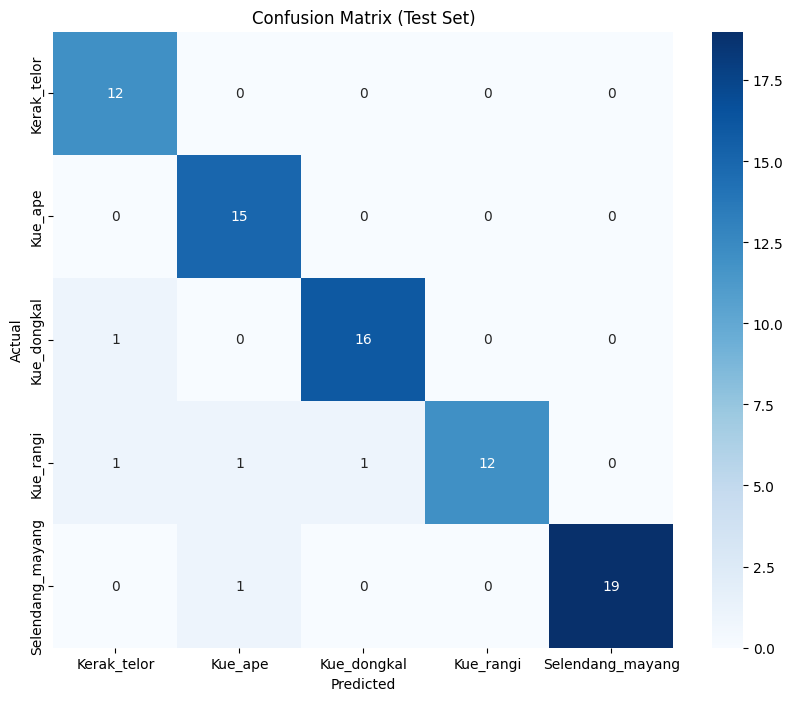

In [21]:
# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix (Test Set)')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

## Hasil akhir evaluasi

In [22]:
# ===== HASIL AKHIR =====
print("\n" + "="*50)
print("HASIL AKHIR EVALUASI")
print("="*50)
print(f"Dataset Split:")
print(f"  - Training: ~70% ({len(train_ds) * BATCH_SIZE} samples)")
print(f"  - Validation: ~20% ({len(val_ds) * BATCH_SIZE} samples)")
print(f"  - Testing: ~10% ({len(test_ds) * BATCH_SIZE} samples)")
print(f"\nModel Performance:")
print(f"  - Validation Accuracy: {val_acc:.4f}")
print(f"  - Test Accuracy: {test_acc:.4f}")
print(f"  - F1 Score (weighted): {f1_weighted:.4f}")
print("="*50)


HASIL AKHIR EVALUASI
Dataset Split:
  - Training: ~70% (640 samples)
  - Validation: ~20% (192 samples)
  - Testing: ~10% (96 samples)

Model Performance:
  - Validation Accuracy: 0.9635
  - Test Accuracy: 0.9367
  - F1 Score (weighted): 0.9362


# Testing


===== REAL-WORLD TESTING (UPLOAD GAMBAR BARU) =====
Silakan upload gambar baru untuk testing model...


Saving kerak-telor4.jpg to kerak-telor4.jpg


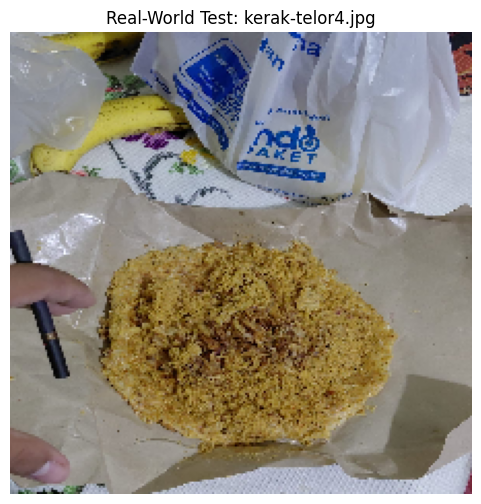


File: kerak-telor4.jpg
Predicted Class: Kerak_telor
Confidence: 0.9998 (99.98%)
(1, 224, 224, 3)


In [23]:
# ===== TESTING DENGAN GAMBAR BARU (REAL-WORLD TESTING) =====
print("\n===== REAL-WORLD TESTING (UPLOAD GAMBAR BARU) =====")
print("Silakan upload gambar baru untuk testing model...")
from tensorflow.keras.preprocessing import image
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
    # Load dan preprocess gambar
    path = fn
    img = image.load_img(path, target_size=IMG_SIZE)

    # Display gambar
    plt.figure(figsize=(6, 6))
    plt.imshow(img)
    plt.title(f"Real-World Test: {fn}")
    plt.axis('off')
    plt.show()

    # Preprocessing
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    # x = x / 255.0  # Normalisasi

    # Prediksi
    predictions = best_model.predict(x, verbose=0)
    predicted_class = np.argmax(predictions, axis=1)[0]
    confidence = predictions[0][predicted_class]

    # Hasil
    print(f"\nFile: {fn}")
    if confidence < 0.75:
      print("Predicted Class: Tidak yakin (kemungkinan gambar tidak dikenali)")
    else:
      print(f"Predicted Class: {class_names[predicted_class]}")
    print(f"Confidence: {confidence:.4f} ({confidence*100:.2f}%)")
    print(x.shape)



# kesimpulan

In [24]:
print("\n" + "="*60)
print("KESIMPULAN EVALUASI")
print("="*60)
print("1. MODEL TELAH DIEVALUASI DENGAN BENAR:")
print(f"   - Test Set Accuracy: {test_acc:.4f}")
print(f"   - F1 Score: {f1_weighted:.4f}")
print("2. REAL-WORLD TESTING DILAKUKAN DENGAN GAMBAR BARU")
print("3. METODOLOGI SESUAI STANDAR MACHINE LEARNING")
print("="*60)


KESIMPULAN EVALUASI
1. MODEL TELAH DIEVALUASI DENGAN BENAR:
   - Test Set Accuracy: 0.9367
   - F1 Score: 0.9362
2. REAL-WORLD TESTING DILAKUKAN DENGAN GAMBAR BARU
3. METODOLOGI SESUAI STANDAR MACHINE LEARNING


In [25]:
top_3_indices = np.argsort(predictions[0])[-3:][::-1]
print("\nTop-3 Predictions:")
for i in top_3_indices:
    print(f"{class_names[i]}: {predictions[0][i]*100:.2f}%")


Top-3 Predictions:
Kerak_telor: 99.98%
Kue_ape: 0.02%
Kue_dongkal: 0.00%
